In [1]:
import datetime 
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Load Data

In [2]:
base_path = './opendataset'

df_israel_covid = pd.read_csv(f'{base_path}/israel_covid_large.csv')
df_israel_isolation_per_day = pd.read_csv(f'{base_path}/corona_isolation_per_day_ver_0059.csv')
df_timeseries_confirm = pd.read_csv(f'{base_path}/time_series_covid19_confirmed_global.csv')

/home/md/anaconda3/envs/flu_screening/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### confrimed data preprocessing and add some columns

In [3]:
rows = []
for idx, values in enumerate(df_timeseries_confirm[df_timeseries_confirm['Country/Region'] == 'Israel'].iteritems()):
    if idx < 4: continue
    year = f"20{values[0][-2:]}"
    month = values[0][:values[0].index('/')]
    month = f'0{month}' if len(month) == 1 else month
    day = values[0][values[0].index('/') + 1 : values[0].rindex('/')]
    day = f'0{day}' if len(day) == 1 else day
    date = f'{year}-{month}-{day}'
    confirmed_num = values[1].item()
    rows.append([date, confirmed_num])
df_numsum_confirmed = pd.DataFrame(rows, columns=['confirmed_date', 'confirmed_numsum'])

In [4]:
df_numsum_confirmed['confirmed_num'] = df_numsum_confirmed['confirmed_numsum'] - df_numsum_confirmed.shift(1)['confirmed_numsum']
df_numsum_confirmed = df_numsum_confirmed.dropna()
df_numsum_confirmed['confirmed_num'] = df_numsum_confirmed['confirmed_num'].astype(int)

In [5]:
for idx, row in df_numsum_confirmed[df_numsum_confirmed['confirmed_num'] < 0].iterrows():
    print("before", df_numsum_confirmed.loc[idx,'confirmed_num'])
    df_numsum_confirmed.loc[idx,'confirmed_num'] = df_numsum_confirmed.loc[idx-1,'confirmed_num']
    print("after", df_numsum_confirmed.loc[idx,'confirmed_num'])
    print()

before -28
after 28

before -53
after 34



In [6]:
df_israel_isolation_per_day['join_date'] = (pd.to_datetime(df_israel_isolation_per_day['date']) + timedelta(days=1)).dt.strftime('%Y-%m-%d')
df_israel_covid['weekday'] = pd.to_datetime(df_israel_covid['test_date']).dt.dayofweek

In [7]:
def date_to_weeknum_map(test_date):
    week_num_st_idx = 52
    year_last_num = int(test_date[2:4])
    week_num = datetime.date(int(test_date[:4]), int(test_date[5:7]), int(test_date[8:])).isocalendar()[1]
    return week_num_st_idx * year_last_num + week_num

In [8]:
df_israel_covid['week_num'] = df_israel_covid['test_date'].apply(date_to_weeknum_map)

### join symptom data, isolation data, confirmed data

In [9]:
df_israel_covid = pd.merge(df_israel_covid, df_israel_isolation_per_day, how='left', left_on='test_date', right_on='join_date')
df_israel_covid = pd.merge(df_israel_covid, df_numsum_confirmed, how='left', left_on='test_date', right_on='confirmed_date')

df_israel_covid = df_israel_covid.sort_values('test_date')

### israel language translated to number

In [10]:
def gender_map(gender):
    if gender == 'נקבה': return 1 #'Female'
    elif gender == 'זכר': return 0 #'Male'
    return -1

In [11]:
def corona_result_map(corona_result):
    if corona_result == 'אחר': return -1 # 'Other'
    elif corona_result == 'שלילי': return 0 # 'Negative'
    elif corona_result == 'חיובי': return 1 # 'Positive'
    return ''

In [12]:
def age_60_and_above_map(age_60_and_above):
    if age_60_and_above == 'Yes': return 1
    elif age_60_and_above == 'No': return 0
    return -1

In [13]:
def test_indication_map(test_indication):
    if test_indication == 'Other': return 0
    elif test_indication == 'Abroad': return 1
    elif  test_indication == 'Contact with confirmed': return 2
    else: return -1

In [14]:
df_israel_covid['gender'] = df_israel_covid['gender'].apply(gender_map)
df_israel_covid['corona_result'] = df_israel_covid['corona_result'].apply(corona_result_map)
df_israel_covid['age_60_and_above'] = df_israel_covid['age_60_and_above'].apply(age_60_and_above_map)
df_israel_covid['test_indication'] = df_israel_covid['test_indication'].apply(test_indication_map)

### crop outlier

In [15]:
df_israel_covid_without_o = df_israel_covid[df_israel_covid['corona_result'] != -1]
df_israel_covid_without_o = df_israel_covid_without_o[df_israel_covid_without_o['gender'] != -1]
df_israel_covid_without_o = df_israel_covid_without_o.sort_values(['test_date']).reset_index(drop=True)

In [16]:
df_israel_covid_without_o['new_contact_with_confirmed'] = df_israel_covid_without_o['new_contact_with_confirmed'].astype(int)

### scaling 

In [17]:
df_israel_covid_without_o['contact'] = df_israel_covid_without_o['new_contact_with_confirmed'] / df_israel_covid_without_o['new_contact_with_confirmed'].max()
df_israel_covid_without_o['confirmed_ratio'] = df_israel_covid_without_o['confirmed_num'] / df_israel_covid_without_o['confirmed_num'].max()
df_israel_covid_without_o['weekday_ratio'] = df_israel_covid_without_o['weekday'] / 6

### dataframe to model input and label

In [18]:
# 증상 5가지, 60세 이상, 성별, 일일 확진자 수(비율), 요일(비율), 코로나 판정 결과 
raw_datas = df_israel_covid_without_o[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'confirmed_ratio', 'weekday_ratio', 'corona_result']].values

In [19]:
input_datas = raw_datas[:, :-1]
gt_datas = raw_datas[:, -1]

### split train, validation, test datasets

In [20]:
def split_train_test(data, test_ratio):
#     shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
#     test_indices = shuffled_indices[:test_set_size]
#     train_indices = shuffled_indices[test_set_size:]
    
    test_data = data[:test_set_size]
    train_data = data[test_set_size:]
#     test_data = data[:test_indices]
#     train_data = data[train_indices:]
    
    return train_data, test_data

In [21]:
def split_input_gt(non_split_data):
    splited_input = non_split_data[:, :-1]
    splited_gt = non_split_data[:, -1]
    
    return splited_input, splited_gt

In [22]:
not_test_datas, test_datas = split_train_test(raw_datas, test_ratio=0.2)
train_datas, valid_datas = split_train_test(not_test_datas, test_ratio=0.2)

train_input, train_gt = split_input_gt(train_datas)
valid_input, valid_gt = split_input_gt(valid_datas)
test_input, test_gt = split_input_gt(test_datas)

In [23]:
print(train_input.shape, train_gt.shape, valid_input.shape, valid_gt.shape, test_input.shape, test_gt.shape)

(3489815, 9) (3489815,) (872453, 9) (872453,) (1090567, 9) (1090567,)


### model training

In [24]:
logistic_clf = LogisticRegression(C=1000.0, random_state=0)
logistic_clf = logistic_clf.fit(train_input, train_gt)

### save model param 

In [25]:
joblib.dump(logistic_clf, 'logistic_israel.pkl') 

['logistic_israel.pkl']

### model performance check with validation data

In [26]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [27]:
def display_performance(pred, valid_gt):
    pred = np.array(pred)

    print('accuracy %.4f' % (accuracy_score(pred, valid_gt)))
    print('precision %.4f' % (precision_score(pred, valid_gt)))
    print('recall %.4f' % (recall_score(pred, valid_gt)))
    print('f1-score %.4f' % (f1_score(pred, valid_gt)))
    print(confusion_matrix(pred, valid_gt))
    fper, tper, thresholds = roc_curve(pred, valid_gt)
    plot_roc_curve(fper, tper)

In [28]:
loaded_logistic_clf = joblib.load('logistic_israel.pkl') 

accuracy 0.8779
precision 0.1514
recall 0.4901
f1-score 0.2313
[[749885  89866]
 [ 16675  16027]]


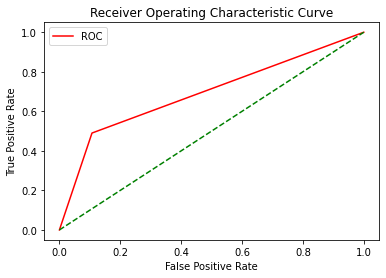

In [29]:
pred = loaded_logistic_clf.predict(valid_input)
display_performance(pred, valid_gt)